<a href="https://colab.research.google.com/github/dishafaujdar/image-Engine/blob/main/searchEngine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1×1 convolution learns what to keep, what to suppress, and how to recombine features, not where they are.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Identity block implementation
class IdentityBlock(nn.Module):
    def __init__(self, in_channels, filters):
        super().__init__()
        f1, f2, f3 = filters
  # filter are the number of output channels the convolutional layers will create. used to identify vertical and horizontal pieces
  # 1×1 convolution learns what to keep, what to suppress, and how to recombine features, not where they are.
  # BatchNormalization adjusting the inputs to each layer—re-centering them around zero and re-scaling them to a standard size
  # Convolutional/Downsampling Block: Used when you want to shrink the image or increase the number of filters.
  # In this case, the x_shortcut must also pass through a $1\times1$ convolution so it "matches" the new shape of x before they are added together.

        # residual path
        # Step 1: 1x1 convolution (to compress channels)
        self.conv1 = nn.Conv2d(in_channels, f1, kernel_size=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(f1)

        # 3x3 convolution (to learn spatial features)
        self.conv2 = nn.Conv2d(f1, f2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(f2)

        # 1x1 convolution (to restore channels to match shortcut)
        self.conv3 = nn.Conv2d(f2, f3, kernel_size=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(f3)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x_shortcut = x

        # residual path
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        # Add shortcut and pass through ReLU
        x += x_shortcut
        x = self.relu(x)

        return x

Squeeze: You take only the 64kg of ingredients you actually need for the recipe.

Process: You cook those 64kg of ingredients into a delicious meal.

Expand: You put that finished meal back into a 256kg container so it fits perfectly on the delivery truck (the shortcut $x$).



---



In [4]:
# Projection convolutional block: bridge between stages
class ProjectionConvBlock(nn.Module):
    def __init__(self, in_channels, filters, stride=2):
        super().__init__()
        f1, f2, f3 = filters

        # The Projection Block is a "bridge." It takes the dimensions from the previous stage
        # and converts them into the dimensions for the new stage.

        # Shortcut path with 1x1 conv to match shape (including stride)
        self.shortcut_conv = nn.Conv2d(in_channels, f3, kernel_size=1, stride=stride, padding=0, bias=False)
        self.shortcut_bn = nn.BatchNorm2d(f3)

        # The main residual part
        # layer 1
        self.conv1 = nn.Conv2d(in_channels, f1, kernel_size=1, stride=stride, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(f1)

        # layer 2
        self.conv2 = nn.Conv2d(f1, f2, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(f2)

        # layer 3
        self.conv3 = nn.Conv2d(f2, f3, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(f3)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x_shortcut = self.shortcut_conv(x)
        x_shortcut = self.shortcut_bn(x_shortcut)

        # main path
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        # addition of shortcut and main path
        x += x_shortcut
        x = self.relu(x)

        return x

This layer extracts 64 coarse features from the image while reducing spatial resolution by half.

Conv: 64 filters, 7×7, stride 2
1. 64 filters
The layer has 64 different kernels
Each kernel learns a different pattern (edges, textures, etc.)
Output has 64 channels (feature maps)
2. 7×7
Each filter is 7 pixels × 7 pixels
Looks at a relatively large spatial region
Common in early layers to capture coarse features
3. Stride = 2
The filter moves 2 pixels at a time
Downsamples the image
Output height and width are roughly halved

In [5]:
# Full ResNet50 architecture

class ResNet50(nn.Module):
    def __init__(self, num_classes=101):
        super().__init__()

        # --- STAGE 0: Entryway ---
        # Zero-padding is handled implicitly by conv padding in PyTorch
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # --- STAGE 1 ---
        self.stage1_proj = ProjectionConvBlock(64, [64, 64, 256], stride=1)
        self.stage1_id1 = IdentityBlock(256, [64, 64, 256])
        self.stage1_id2 = IdentityBlock(256, [64, 64, 256])

        # --- STAGE 2 ---
        self.stage2_proj = ProjectionConvBlock(256, [128, 128, 512], stride=2)
        self.stage2_id1 = IdentityBlock(512, [128, 128, 512])
        self.stage2_id2 = IdentityBlock(512, [128, 128, 512])
        self.stage2_id3 = IdentityBlock(512, [128, 128, 512])

        # --- STAGE 3 ---
        self.stage3_proj = ProjectionConvBlock(512, [256, 256, 1024], stride=2)
        self.stage3_id1 = IdentityBlock(1024, [256, 256, 1024])
        self.stage3_id2 = IdentityBlock(1024, [256, 256, 1024])
        self.stage3_id3 = IdentityBlock(1024, [256, 256, 1024])
        self.stage3_id4 = IdentityBlock(1024, [256, 256, 1024])
        self.stage3_id5 = IdentityBlock(1024, [256, 256, 1024])

        # --- STAGE 4 ---
        self.stage4_proj = ProjectionConvBlock(1024, [512, 512, 2048], stride=2)
        self.stage4_id1 = IdentityBlock(2048, [512, 512, 2048])
        self.stage4_id2 = IdentityBlock(2048, [512, 512, 2048])

        # --- FINAL: Output Stage ---
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)

    # def forward(self, x):
    #     # Stage 0
    #     x = self.conv1(x)
    #     x = self.bn1(x)
    #     x = self.relu(x)
    #     x = self.maxpool(x)

    #     # Stage 1
    #     x = self.stage1_proj(x)
    #     x = self.stage1_id1(x)
    #     x = self.stage1_id2(x)

    #     # Stage 2
    #     x = self.stage2_proj(x)
    #     x = self.stage2_id1(x)
    #     x = self.stage2_id2(x)
    #     x = self.stage2_id3(x)

    #     # Stage 3
    #     x = self.stage3_proj(x)
    #     x = self.stage3_id1(x)
    #     x = self.stage3_id2(x)
    #     x = self.stage3_id3(x)
    #     x = self.stage3_id4(x)
    #     x = self.stage3_id5(x)

    #     # Stage 4
    #     x = self.stage4_proj(x)
    #     x = self.stage4_id1(x)
    #     x = self.stage4_id2(x)

    #     # Final layers
    #     x = self.avgpool(x)
    #     # will store this layer and compare it to the input image vector
    #     x = torch.flatten(x, 1)
    #     print("feature layer:",torch.flatten(x, 1))
    #     x = self.fc(x)

    #     return x

    def forward(self, x):
      # Stage 0
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.maxpool(x)

      # Stage 1
      x = self.stage1_proj(x)
      x = self.stage1_id1(x)
      x = self.stage1_id2(x)

      # Stage 2
      x = self.stage2_proj(x)
      x = self.stage2_id1(x)
      x = self.stage2_id2(x)
      x = self.stage2_id3(x)

      # Stage 3
      x = self.stage3_proj(x)
      x = self.stage3_id1(x)
      x = self.stage3_id2(x)
      x = self.stage3_id3(x)
      x = self.stage3_id4(x)
      x = self.stage3_id5(x)

      # Stage 4
      x = self.stage4_proj(x)
      x = self.stage4_id1(x)
      x = self.stage4_id2(x)

      # Stop here - don't go to fc
      x = self.avgpool(x)
      x = torch.flatten(x, 1)

      return x  # 2048-dim feature vector

In [40]:
import torchvision
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Download Caltech-101
dataset = torchvision.datasets.Caltech101(
    root='./data',
    download=True,
    transform = preprocess
)

print(f"Total images: {len(dataset)}")
print(f"Number of classes: {len(dataset.categories)}")

Total images: 8677
Number of classes: 101


In [7]:
# train test split
from torch.utils.data import random_split

train_split = int(0.8 * len(dataset))
test_split = len(dataset) - train_split
train_dataset, test_dataset = random_split(dataset, [train_split, test_split])


In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [9]:
import torch
import torch.nn as nn

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model
model = ResNet50(num_classes=101).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet50(num_classes=101).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    avg_loss = running_loss / len(train_loader)

    # Testing phase
    model.eval()
    test_correct = 0
    test_total = 0
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    test_acc = 100. * test_correct / test_total
    avg_test_loss = test_loss / len(test_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'  Train Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'  Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.2f}%')

Epoch [1/20]
  Train Loss: 5.0906, Train Acc: 22.37%
  Test Loss: 4.2441, Test Acc: 28.05%
Epoch [2/20]
  Train Loss: 4.0556, Train Acc: 29.43%
  Test Loss: 4.0403, Test Acc: 26.38%
Epoch [3/20]
  Train Loss: 3.5471, Train Acc: 34.75%
  Test Loss: 3.4712, Test Acc: 36.12%
Epoch [4/20]
  Train Loss: 3.1101, Train Acc: 39.01%
  Test Loss: 2.8835, Test Acc: 42.28%
Epoch [5/20]
  Train Loss: 2.6741, Train Acc: 44.52%
  Test Loss: 2.5665, Test Acc: 47.58%
Epoch [6/20]
  Train Loss: 2.2888, Train Acc: 50.41%
  Test Loss: 2.1532, Test Acc: 53.17%
Epoch [7/20]
  Train Loss: 1.9642, Train Acc: 55.87%
  Test Loss: 2.0717, Test Acc: 54.26%
Epoch [8/20]
  Train Loss: 1.6597, Train Acc: 61.58%
  Test Loss: 1.7452, Test Acc: 60.77%
Epoch [9/20]
  Train Loss: 1.3660, Train Acc: 67.77%
  Test Loss: 1.4747, Test Acc: 65.67%
Epoch [10/20]
  Train Loss: 1.1634, Train Acc: 72.38%
  Test Loss: 1.4090, Test Acc: 67.05%
Epoch [11/20]
  Train Loss: 0.9405, Train Acc: 78.04%
  Test Loss: 1.3405, Test Acc: 66.8

In [37]:
torch.save(model.state_dict(), 'resnet50_caltech101.pth')

torch.no_grad() is a context manager in PyTorch that disables gradient computation for all operations within its scope.  It is primarily used during inference, validation, or evaluation when you are sure you won't call Tensor.backward().

i'm using caltech's 101 image data, and i am building a image search engine, for that i've already trained the data and the model and wrote fn for feature extraction, and now i've to save those extracted those features and save them in array foramt (due to small size) so that when user give an image as input model can use it to search that image. am i goin in right

In [39]:
# Debug: see what one sample looks like
sample = dataset[0]
print(f"Sample type: {type(sample)}")
print(f"Number of items: {len(sample) if isinstance(sample, tuple) else 'not a tuple'}")

Sample type: <class 'tuple'>
Number of items: 2


In [41]:
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm

# Load trained model
model = ResNet50(num_classes=101)  # Create instance
model.load_state_dict(torch.load('resnet50_caltech101.pth', map_location='cpu'))
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Extract features using DataLoader
from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=32, shuffle=False)

all_features = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(loader):
        images = images.to(device)
        features = model(images)  # (batch, 2048)

        all_features.append(features.cpu().numpy())
        all_labels.extend(labels.numpy())

# 6. Save features
features_array = np.concatenate(all_features, axis=0)
labels_array = np.array(all_labels)

np.savez(
    'features_database.npz',
    features=features_array,
    labels=labels_array
)

print(f"Saved features shape: {features_array.shape}")


100%|██████████| 272/272 [00:48<00:00,  5.61it/s]


Saved features shape: (8677, 2048)


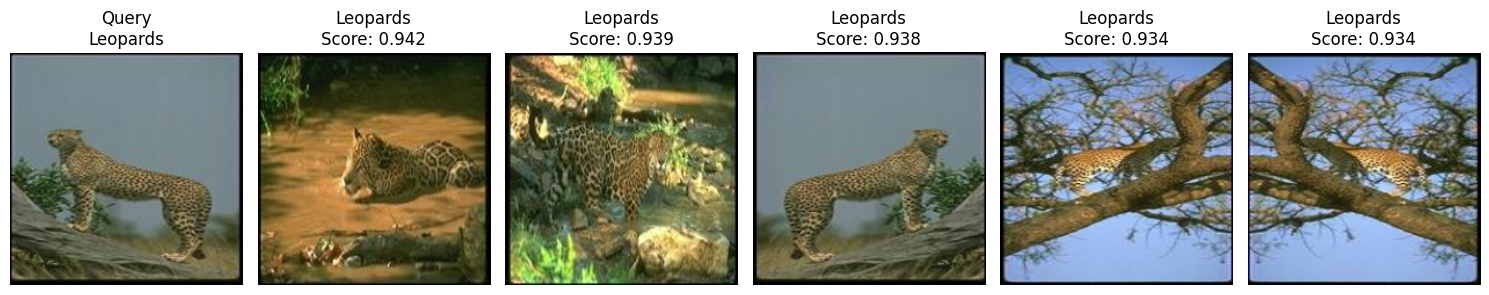

In [19]:
import numpy as np
from numpy.linalg import norm
from PIL import Image
import matplotlib.pyplot as plt

def search_similar(query_index, top_k=5):
    """
    Test using an image from the dataset itself
    query_index: index of image in dataset to use as query
    """
    # Load saved features
    data = np.load('features_database.npz')
    db_features = data['features']
    db_labels = data['labels']

    query_features = db_features[query_index]
    query_label = db_labels[query_index]

    query_norm = query_features / norm(query_features)
    db_norm = db_features / norm(db_features, axis=1, keepdims=True)

    similarities = np.dot(db_norm, query_norm)

    top_indices = np.argsort(similarities)[::-1][1:top_k+1]

    return query_index, query_label, top_indices, db_labels[top_indices], similarities[top_indices]


def visualize_results(query_idx, top_k=5):
    """Visualize query and results"""
    query_index, query_label, result_indices, result_labels, scores = search_similar(query_idx, top_k)

    class_names = dataset.categories

    fig, axes = plt.subplots(1, top_k + 1, figsize=(15, 3))

    query_img, _ = dataset[query_index]
    query_img = query_img.permute(1, 2, 0).numpy()
    query_img = query_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    query_img = np.clip(query_img, 0, 1)

    axes[0].imshow(query_img)
    axes[0].set_title(f"Query\n{class_names[query_label]}")
    axes[0].axis('off')

    # Show results
    for i, (idx, label, score) in enumerate(zip(result_indices, result_labels, scores)):
        img, _ = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        axes[i + 1].imshow(img)
        axes[i + 1].set_title(f"{class_names[label]}\nScore: {score:.3f}")
        axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()


visualize_results(query_idx=1000, top_k=5)

In [20]:
from torchvision import transforms
from PIL import Image

preprocess = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

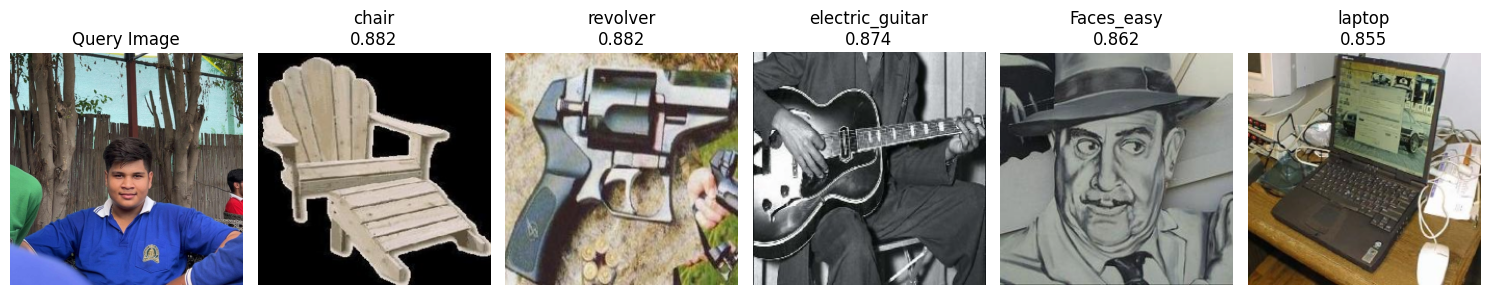

In [28]:
def search_with_new_image(image_path, top_k=5, threshold=0.42):
    """Search using a new image not in dataset"""


    img = Image.open(image_path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        query_features = model(img_tensor).cpu().numpy().flatten()

    data = np.load('features_database.npz')
    db_features = data['features']
    db_labels = data['labels']

    query_norm = query_features / norm(query_features)
    db_norm = db_features / norm(db_features, axis=1, keepdims=True)
    similarities = np.dot(db_norm, query_norm)

    # Top results
    top_indices = np.argsort(similarities)[::-1][:top_k]

    class_names = dataset.categories
    fig, axes = plt.subplots(1, top_k + 1, figsize=(15, 3))

    axes[0].imshow(img)
    axes[0].set_title("Query Image")
    axes[0].axis('off')

    # Results
    for i, idx in enumerate(top_indices):
        result_img, _ = dataset[idx]
        result_img = result_img.permute(1, 2, 0).numpy()
        result_img = result_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        result_img = np.clip(result_img, 0, 1)

        axes[i + 1].imshow(result_img)
        axes[i + 1].set_title(f"{class_names[db_labels[idx]]}\n{similarities[idx]:.3f}")
        axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

search_with_new_image('/content/WhatsApp Image 2026-01-16 at 19.22.40.jpeg', top_k=5)

In [22]:
def evaluate_search(num_queries=100):
    """Check if top result is same class as query"""
    data = np.load('features_database.npz')
    db_features = data['features']
    db_labels = data['labels']

    # Normalize all features once
    db_norm = db_features / norm(db_features, axis=1, keepdims=True)

    correct = 0
    np.random.seed(42)
    test_indices = np.random.choice(len(db_features), num_queries, replace=False)

    for idx in test_indices:
        query = db_norm[idx]
        similarities = np.dot(db_norm, query)

        # Get top match (excluding itself)
        top_match = np.argsort(similarities)[::-1][1]

        if db_labels[top_match] == db_labels[idx]:
            correct += 1

    accuracy = correct / num_queries * 100
    print(f"Top-1 Retrieval Accuracy: {accuracy:.2f}%")
    return accuracy

evaluate_search(num_queries=200)

Top-1 Retrieval Accuracy: 93.50%


93.5